In [1]:
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import json, rasterio
from shapely.geometry import box
from fiona.crs import from_epsg
from rasterio.mask import mask

import os, re
from rasterio.merge import merge
from tqdm import tqdm_notebook as tqdmn
from rasterio import plot
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
sns.set_style("white")
plt.style.use('bmh')

# Generate `FR/110`

In [2]:
census_dir = "/warehouse/COMPLEXNET/jlevyabi/REPLICATE_LINGSES/data_files/census_data/france-geojson/"
base_dir = "/warehouse/COMPLEXNET/jlevyabi/SATELSES/equirect_proj_test/cnes/data_files/esa/FR/110_L3_European/"

In [3]:
census_shp = gpd.read_file(census_dir + "arrondissements.geojson")

In [4]:
census_shp.plot();

In [5]:
shape_files = []
for f in os.listdir(base_dir):
    shape_files += [base_dir + f + "/GIS_FILES/" + y
                    for x in os.listdir(base_dir + f)
                    if "GIS_FILES" in os.listdir(base_dir + f)
                    for y in os.listdir(base_dir + f + "/GIS_FILES/")
                    if y.endswith("_TILE_SHAPE.shp")]

shape_files = list(set(shape_files))
gpd_fr_110 = pd.concat([gpd.read_file(x) for x in shape_files])

In [6]:
import xmltodict
tif_list = []

for f_name in os.listdir(base_dir):
    if f_name.endswith("-FR110E"):
        with open(base_dir + "%s/%s_README.XML"%(f_name,f_name)) as fd:
            doc = xmltodict.parse(fd.read())
            tif_list += [(base_dir + f_name + "/" + "".join(x.split("\\")[0]),
                          x.replace("\\","/"),x.split("\\")[-1]) 
                        for x in doc["README"]["FILELIST"]["FILE"] 
                        if x.endswith(".TIF")]
            
pd_tif_list = pd.DataFrame(tif_list,columns=["full_file","file","fileName"])
gpd_full_shp_info = gpd.GeoDataFrame(pd.merge(pd_tif_list,gpd_fr_110,on="fileName"))
census_fr_110 = gpd.sjoin(census_shp,
                          gpd_full_shp_info)[["code","nom","geometry"]].drop_duplicates(subset=["code","nom"])

In [10]:
pd_tif_list.iloc[0]["full_file"] + "/" + pd_tif_list.iloc[0]["fileName"]

'/warehouse/COMPLEXNET/jlevyabi/SATELSES/equirect_proj_test/cnes/data_files/esa/FR/110_L3_European/055387182100_01-FR110E/055387182100_01_P001-FR110E_MUL/15SEP11105315-M3XS_R1C1-055387182100_01_P001-FR110E.TIF'

There are overlapping satellite tiles


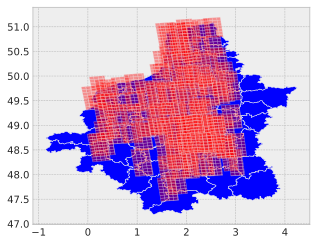

In [9]:
print("There are overlapping satellite tiles");
f,ax = plt.subplots(1,1,figsize=(7,4))
census_fr_110.plot(ax=ax,label="Arrondissement");
gpd_full_shp_info[["_PAN" in x for x in gpd_full_shp_info.file]].plot(color="red",alpha=0.4,ax=ax,label="Satellite");
# I only take panchromatic so as not to get twice the same tile (PAN + MS)

# Algorithm Pipeline

- __Sample cells from INSEE dataset__ 

- __Extract tiles from satellite dataset__ 

- __Train Network__

## Sampling from INSEE

In [11]:
base_dir = '/warehouse/COMPLEXNET/jlevyabi/REPLICATE_LINGSES/data_files/census_data/'

# Generate Carres gdf
df_car = GeoDataFrame.from_file(base_dir + "200m-carreaux-metropole/car_m.dbf")
df_car_data = GeoDataFrame.from_file(base_dir + "200m-carreaux-metropole/car_m.mif")
df_car_final=pd.merge(df_car_data,df_car,how="inner",on="idINSPIRE")
df_car_final.drop(["id_y","geometry_y"],inplace=True,axis=1)
df_car_final.columns = ['idINSPIRE', 'id','geometry','idk','ind_c','nbcar']
df_car_final = df_car_final.to_crs({'init': 'epsg:4326'})

df_rec = GeoDataFrame.from_file(base_dir + "200m-rectangles-metropole/rect_m.dbf")
df_rec_data = GeoDataFrame.from_file(base_dir + "200m-rectangles-metropole/rect_m.mif")
df_rec_final=pd.merge(df_rec,df_rec_data,how="inner",on="idk")
df_rec_final.drop("geometry_x",inplace=True,axis=1)
temp=list(df_rec_final.columns)
temp[-1]="geometry"
df_rec_final.columns=temp
df_rec_final.crs = df_car_data.crs
df_rec_final = df_rec_final.to_crs({'init': 'epsg:4326'})
# Reprojecting into epsg:4326
df_rec_final["income"] = df_rec_final.ind_srf/df_rec_final.ind_r

# Merging squares and rectangles
df_geo_final=pd.merge(df_car_final,df_rec_final,how="inner",on="idk",suffixes=('_car','_rec'))
df_geo_final["geometry"]=df_geo_final["geometry_car"]
df_geo_final.drop(["geometry_car","geometry_rec"],inplace=True,axis=1)

In [12]:
df_geo_final_110 = gpd.sjoin(df_geo_final,census_fr_110)

In [ ]:
plt.hist(df_geo_final_110.sample(frac=0.8).income,bins=100,);
plt.title("Random Sampling would work");
plt.xlabel("Income");
plt.ylabel("#");

Now craft way to __map census cell to satellite tile__

In [13]:
census_sat_tile = gpd.sjoin(df_geo_final_110.drop(["index_right"],axis=1),gpd_full_shp_info)
# Multiple tiles per census block since there are overlapping tiles + multiple bands(PAN + MUL)
census_sat_tile_no_dup = census_sat_tile.sample(frac=1).drop_duplicates(["idINSPIRE"])
census_sat_tile_no_dup["owner_ratio"] = census_sat_tile_no_dup["men_prop"]/census_sat_tile_no_dup["men"]
census_sat_tile_no_dup["pov_rate"] = census_sat_tile_no_dup["men_basr"]/census_sat_tile_no_dup["men"]
census_sat_tile_no_dup["density"] = census_sat_tile_no_dup["men_basr"]/census_sat_tile_no_dup["men"]

In [212]:
test_row = census_sat_tile_no_dup.sample(1).iloc[0]
full_info =  (test_row.geometry,test_row.income,test_row.owner_ratio,test_row.i_prop,
              test_row.pov_rate,test_row.i_basr,test_row.ind_c,test_row.ind_c/(0.2*0.2),
              test_row["full_file"]+"/"+test_row["fileName"])
#
geom, income, owner_ratio, ind_or, pov_rate, ind_pov, nb_ind, density, fname = full_info

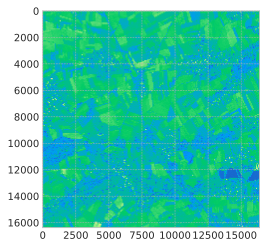

In [213]:
#ax = plt.axes(projection=crs)
rasterio.plot.show(rasterio.open(fname).read(),cmap="terrain");

In [214]:
data = rasterio.open(fname)
minx, miny, maxx, maxy = geom.bounds
bbox = box(minx, miny, maxx, maxy)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
geo = geo.to_crs(crs=data.crs.data)

def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [215]:
coords = getFeatures(geo)
out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)
out_meta = data.meta.copy()
epsg_code = int(data.crs.data['init'][5:])

out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": data.crs})

In [216]:
def crop_image(img,tol=1e-8):
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

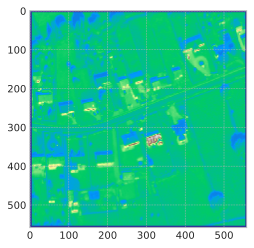

In [218]:
from scipy.ndimage import rotate
rot_test = rotate(out_img[0,:,:],6)
plt.imshow(crop_image(rot_test),cmap='terrain');

## Clean Satellite Images

In [116]:
esa_dir="/warehouse/COMPLEXNET/jlevyabi/SATELSES/equirect_proj_test/cnes/data_files/esa/FR/"
current_region = "110_L3_European/"
sat_dirs = [esa_dir + current_region + f for f in os.listdir(esa_dir + current_region) if f.endswith("FR110E")]

In [198]:
corr_data = []
non_currs = 0
for sat_dir in sat_dirs:
    all_dirs = os.listdir(sat_dir)
    pan_dir = sat_dir + "/" + [x for x in all_dirs if x.endswith("_PAN")][0]
    mul_dir = sat_dir + "/" + [x for x in all_dirs if x.endswith("_MUL")][0]
    pan_files = sorted(os.listdir(pan_dir))
    mul_files = sorted(os.listdir(mul_dir))
    if len(pan_files) != len(mul_files):
        non_currs += 1
    for pan_file,mul_file in zip(pan_files,mul_files):
        if pan_file.endswith(".TIF") and mul_file.endswith(".TIF"):
            corr_data.append((pan_dir + "/" + pan_file, mul_dir + "/" + mul_file))
            
corr_data_df = pd.DataFrame(corr_data,columns=["pan","ms"])
corr_data_df.to_csv(esa_dir + current_region + "pansharpened_ims.csv",sep=" ",index=False,header=False)